Graph 1 for SMILES CC(=O)NC1=CC=C(C=C1)O:
Adjacency Matrix:
 [[0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]]
Node Features:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 

/tmp/ipykernel_5505/1184522708.py:22: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return np.array(nx.adjacency_matrix(graph).todense())


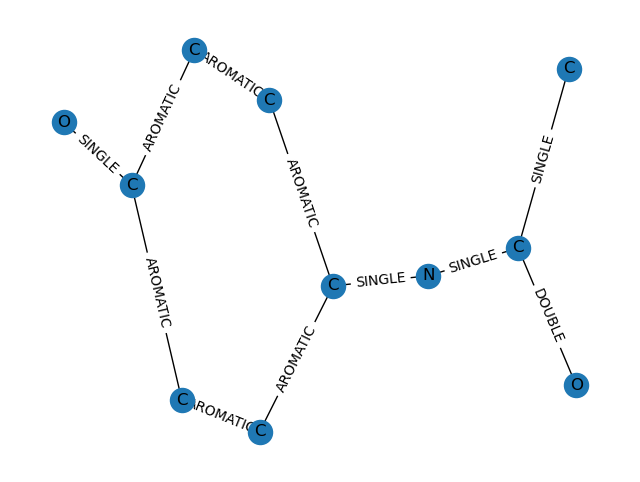

In [9]:
import numpy as np
import networkx as nx
from rdkit import Chem
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Function to convert SMILES to a NetworkX graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), symbol=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    return graph

# Function to create an adjacency matrix from a NetworkX graph
def create_adjacency_matrix(graph):
    return np.array(nx.adjacency_matrix(graph).todense())

# Function to create node features based on the specified dimensions
def create_node_features(mol):
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of the atom element
        element = atom.GetSymbol()
        element_one_hot = [0] * 44
        element_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']
        if element in element_list:
            element_one_hot[element_list.index(element)] = 1

        # One-hot encoding of the degree of the atom in the molecule
        degree = atom.GetDegree()
        degree_one_hot = [0] * 11
        if degree < 11:
            degree_one_hot[degree] = 1

        # One-hot encoding of the total number of H bound to the atom
        total_num_h = atom.GetTotalNumHs()
        total_num_h_one_hot = [0] * 11
        if total_num_h < 11:
            total_num_h_one_hot[total_num_h] = 1

        # One-hot encoding of the number of implicit H bound to the atom
        implicit_h = atom.GetNumImplicitHs()
        implicit_h_one_hot = [0] * 11
        if implicit_h < 11:
            implicit_h_one_hot[implicit_h] = 1

        # Whether the atom is aromatic
        aromatic = [1] if atom.GetIsAromatic() else [0]

        # Combine all features
        atom_features.append(element_one_hot + degree_one_hot + total_num_h_one_hot + implicit_h_one_hot + aromatic)

    return np.array(atom_features)

# Process data to PyTorch Geometric Data format
def process_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        graph = smiles_to_graph(smiles)
        x = torch.tensor(create_node_features(mol), dtype=torch.float)
        edge_index = torch.tensor(create_adjacency_matrix(graph).nonzero(), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
    return data_list

smiles_list = ['CC(=O)NC1=CC=C(C=C1)O']
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

for i, graph in enumerate(graphs):
    if graph is not None:
        print(f"Graph {i + 1} for SMILES {smiles_list[i]}:")
        print("Adjacency Matrix:\n", create_adjacency_matrix(graph))
        print("Node Features:\n", create_node_features(Chem.MolFromSmiles(smiles_list[i])))
        
        # Draw the graph using matplotlib
        plt.figure(figsize=(8, 6))
        ax = plt.gca()  # Get current axis
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, labels=nx.get_node_attributes(graph, 'symbol'), ax=ax)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'bond_type'), ax=ax)
        plt.show()


Graph 1 for SMILES CC(=O)NC1=CC=C(C=C1)O:
Adjacency Matrix:
   (0, 0)	1
  (0, 1)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (2, 1)	1
  (2, 2)	1
  (3, 1)	1
  (3, 3)	1
  (3, 4)	1
  (4, 3)	1
  (4, 4)	1
  (4, 5)	1
  (4, 9)	1
  (5, 4)	1
  (5, 5)	1
  (5, 6)	1
  (6, 5)	1
  (6, 6)	1
  (6, 7)	1
  (7, 6)	1
  (7, 7)	1
  (7, 8)	1
  (7, 10)	1
  (8, 7)	1
  (8, 8)	1
  (8, 9)	1
  (9, 4)	1
  (9, 8)	1
  (9, 9)	1
  (10, 7)	1
  (10, 10)	1
Node Features:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

/tmp/ipykernel_5505/4284186845.py:25: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph)


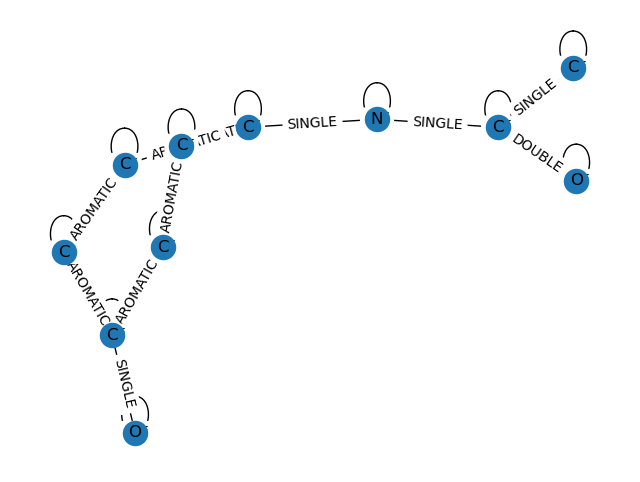

In [10]:
import numpy as np
import networkx as nx
from rdkit import Chem
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Function to convert SMILES to a NetworkX graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), symbol=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
        # Add self-loop for each atom
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetBeginAtomIdx(), bond_type='self')
        graph.add_edge(bond.GetEndAtomIdx(), bond.GetEndAtomIdx(), bond_type='self')
    return graph

# Function to create an adjacency matrix from a NetworkX graph (sparse representation)
def create_adjacency_matrix(graph):
    return nx.adjacency_matrix(graph)

# Function to create node features based on the specified dimensions
def create_node_features(mol):
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of the atom element
        element = atom.GetSymbol()
        element_one_hot = [0] * 44
        element_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']
        if element in element_list:
            element_one_hot[element_list.index(element)] = 1

        # One-hot encoding of the degree of the atom in the molecule
        degree = atom.GetDegree()
        degree_one_hot = [0] * 11
        if degree < 11:
            degree_one_hot[degree] = 1

        # One-hot encoding of the total number of H bound to the atom
        total_num_h = atom.GetTotalNumHs()
        total_num_h_one_hot = [0] * 11
        if total_num_h < 11:
            total_num_h_one_hot[total_num_h] = 1

        # One-hot encoding of the number of implicit H bound to the atom
        implicit_h = atom.GetNumImplicitHs()
        implicit_h_one_hot = [0] * 11
        if implicit_h < 11:
            implicit_h_one_hot[implicit_h] = 1

        # Whether the atom is aromatic
        aromatic = [1] if atom.GetIsAromatic() else [0]

        # Combine all features
        atom_features.append(element_one_hot + degree_one_hot + total_num_h_one_hot + implicit_h_one_hot + aromatic)

    return np.array(atom_features)

# Process data to PyTorch Geometric Data format
def process_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        graph = smiles_to_graph(smiles)
        x = torch.tensor(create_node_features(mol), dtype=torch.float)
        edge_index = torch.tensor(create_adjacency_matrix(graph).nonzero(), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
    return data_list

# Example usage with a single SMILES string
smiles_list = ['CC(=O)NC1=CC=C(C=C1)O']
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

for i, graph in enumerate(graphs):
    if graph is not None:
        print(f"Graph {i + 1} for SMILES {smiles_list[i]}:")
        print("Adjacency Matrix:\n", create_adjacency_matrix(graph))
        print("Node Features:\n", create_node_features(Chem.MolFromSmiles(smiles_list[i])))
        
        # Draw the graph using matplotlib
        plt.figure(figsize=(8, 6))
        ax = plt.gca()  # Get current axis
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, labels=nx.get_node_attributes(graph, 'symbol'), ax=ax)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'bond_type'), ax=ax)
        plt.show()


Graph 1 for SMILES CC(=O)NC1=CC=C(C=C1)O:
Node 1:
Element (one-hot encoding): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 2:
Element (one-hot encoding): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 3:
Element (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indi

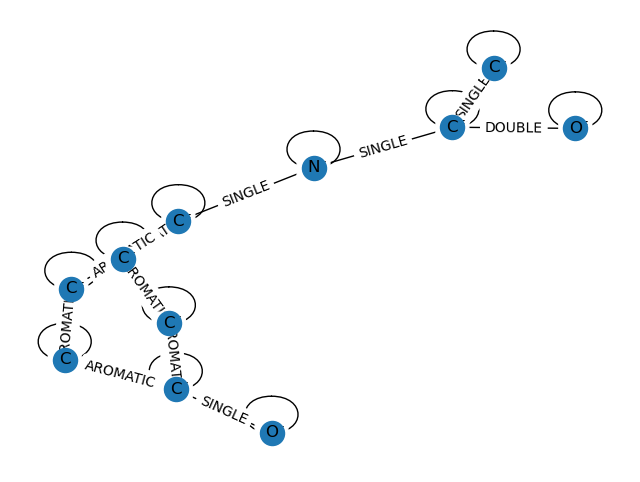

In [12]:
import numpy as np
import networkx as nx
from rdkit import Chem
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Function to convert SMILES to a NetworkX graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), symbol=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
        # Add self-loop for each atom
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetBeginAtomIdx(), bond_type='self')
        graph.add_edge(bond.GetEndAtomIdx(), bond.GetEndAtomIdx(), bond_type='self')
    return graph

# Function to create an adjacency matrix from a NetworkX graph (sparse representation)
def create_adjacency_matrix(graph):
    return nx.adjacency_matrix(graph)

# Function to create node features based on the specified dimensions
def create_node_features(mol):
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of the atom element
        element = atom.GetSymbol()
        element_one_hot = [0] * 44
        element_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']
        if element in element_list:
            element_one_hot[element_list.index(element)] = 1

        # One-hot encoding of the degree of the atom in the molecule
        degree = atom.GetDegree()
        degree_one_hot = [0] * 11
        if degree < 11:
            degree_one_hot[degree] = 1

        # One-hot encoding of the total number of H bound to the atom
        total_num_h = atom.GetTotalNumHs()
        total_num_h_one_hot = [0] * 11
        if total_num_h < 11:
            total_num_h_one_hot[total_num_h] = 1

        # One-hot encoding of the number of implicit H bound to the atom
        implicit_h = atom.GetNumImplicitHs()
        implicit_h_one_hot = [0] * 11
        if implicit_h < 11:
            implicit_h_one_hot[implicit_h] = 1

        # Whether the atom is aromatic
        aromatic = [1] if atom.GetIsAromatic() else [0]

        # Combine all features
        atom_features.append(element_one_hot + degree_one_hot + total_num_h_one_hot + implicit_h_one_hot + aromatic)

    return np.array(atom_features)

# Process data to PyTorch Geometric Data format
def process_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        graph = smiles_to_graph(smiles)
        x = torch.tensor(create_node_features(mol), dtype=torch.float)
        edge_index = torch.tensor(create_adjacency_matrix(graph).nonzero(), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        data_list.append(data)
    return data_list

# Example usage with a single SMILES string
smiles_list = ['CC(=O)NC1=CC=C(C=C1)O']
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

for i, graph in enumerate(graphs):
    if graph is not None:
        print(f"Graph {i + 1} for SMILES {smiles_list[i]}:")
        mol = Chem.MolFromSmiles(smiles_list[i])
        node_features = create_node_features(mol)
        for idx, features in enumerate(node_features):
            print(f"Node {idx + 1}:")
            print(f"Element (one-hot encoding): {features[0:44]}")
            print(f"Degree (one-hot encoding): {features[44:55]}")
            print(f"Total number of H (one-hot encoding): {features[55:66]}")
            print(f"Implicit H (one-hot encoding): {features[66:77]}")
            print(f"Aromaticity (indicator): {features[77]}")
            print()

        # Draw the graph using matplotlib
        plt.figure(figsize=(8, 6))
        ax = plt.gca()  # Get current axis
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, labels=nx.get_node_attributes(graph, 'symbol'), ax=ax)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'bond_type'), ax=ax)
        plt.show()


Graph 1 for SMILES CC(=O)NC1=CC=C(C=C1)O:
Node 1:
Element (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 2:
Element (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 3:
Element (one-hot encoding): [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indi

/tmp/ipykernel_5505/1542260484.py:25: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph)


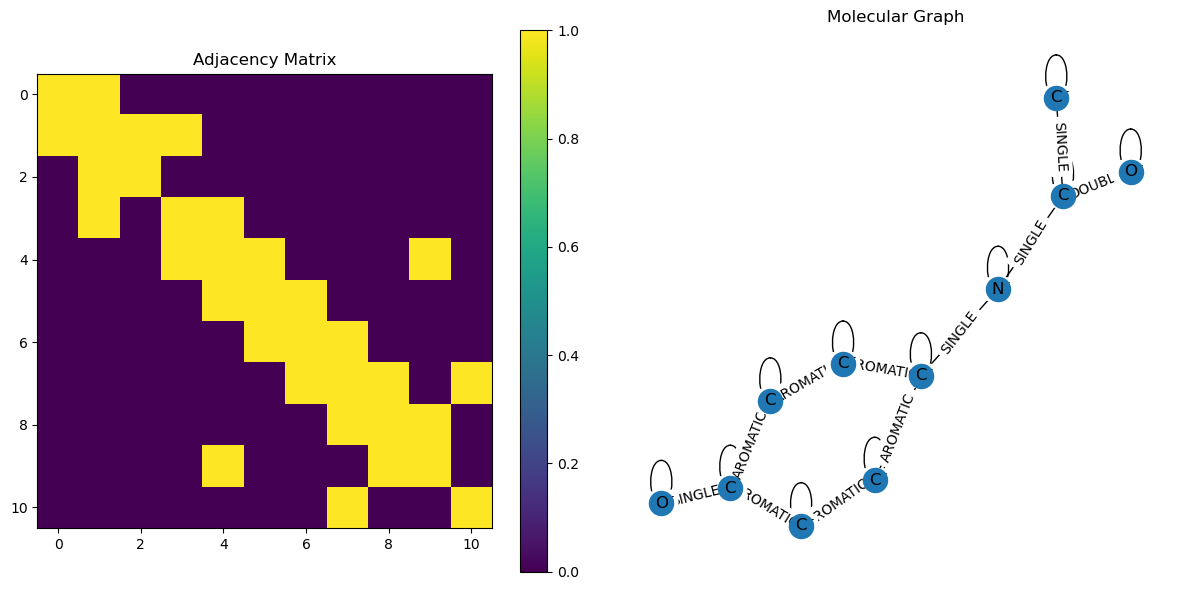

In [15]:
import numpy as np
import networkx as nx
from rdkit import Chem
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Function to convert SMILES to a NetworkX graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), symbol=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
        # Add self-loop for each atom
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetBeginAtomIdx(), bond_type='self')
        graph.add_edge(bond.GetEndAtomIdx(), bond.GetEndAtomIdx(), bond_type='self')
    return graph

# Function to create an adjacency matrix from a NetworkX graph (sparse representation)
def create_adjacency_matrix(graph):
    return nx.adjacency_matrix(graph)

# Function to create node features based on the specified dimensions
def create_node_features(mol):
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of the atom element
        element = atom.GetSymbol()
        element_one_hot = [0] * 44
        element_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']
        if element in element_list:
            element_one_hot[element_list.index(element)] = 1

        # One-hot encoding of the degree of the atom in the molecule
        degree = atom.GetDegree()
        degree_one_hot = [0] * 11
        if degree < 11:
            degree_one_hot[degree] = 1

        # One-hot encoding of the total number of H bound to the atom
        total_num_h = atom.GetTotalNumHs()
        total_num_h_one_hot = [0] * 11
        if total_num_h < 11:
            total_num_h_one_hot[total_num_h] = 1

        # One-hot encoding of the number of implicit H bound to the atom
        implicit_h = atom.GetNumImplicitHs()
        implicit_h_one_hot = [0] * 11
        if implicit_h < 11:
            implicit_h_one_hot[implicit_h] = 1

        # Whether the atom is aromatic
        aromatic = [1] if atom.GetIsAromatic() else [0]

        # Combine all features
        atom_features.append(element_one_hot + degree_one_hot + total_num_h_one_hot + implicit_h_one_hot + aromatic)

    return np.array(atom_features)

# Process data to PyTorch Geometric Data format
def process_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        graph = smiles_to_graph(smiles)
        x = torch.tensor(create_node_features(mol), dtype=torch.float)
        adj_matrix = create_adjacency_matrix(graph)
        edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        data_list.append((data, adj_matrix))
    return data_list

# Example usage with a single SMILES string
smiles_list = ['CC(=O)NC1=CC=C(C=C1)O']
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

for i, graph in enumerate(graphs):
    if graph is not None:
        print(f"Graph {i + 1} for SMILES {smiles_list[i]}:")
        mol = Chem.MolFromSmiles(smiles_list[i])
        node_features = create_node_features(mol)
        for idx, features in enumerate(node_features):
            print(f"Node {idx + 1}:")
            print(f"Element (one-hot encoding): {features[0:44]}")
            print(f"Degree (one-hot encoding): {features[44:55]}")
            print(f"Total number of H (one-hot encoding): {features[55:66]}")
            print(f"Implicit H (one-hot encoding): {features[66:77]}")
            print(f"Aromaticity (indicator): {features[77]}")
            print()

        # Draw the graph using matplotlib
        plt.figure(figsize=(12, 6))

        # Plot adjacency matrix as a heatmap
        adj_matrix = create_adjacency_matrix(graph).todense()
        plt.subplot(1, 2, 1)
        plt.imshow(adj_matrix, cmap='viridis', interpolation='nearest')
        plt.title('Adjacency Matrix')
        plt.colorbar()

        # Plot the molecular graph
        plt.subplot(1, 2, 2)
        ax = plt.gca()  # Get current axis
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, labels=nx.get_node_attributes(graph, 'symbol'), ax=ax)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'bond_type'), ax=ax)
        plt.title('Molecular Graph')
        plt.tight_layout()
        plt.show()


Graph 1 for SMILES CC(=O)NC1=CC=C(C=C1)O:
Node 1:
Element (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 2:
Element (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 0 0 1 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indicator): 0

Node 3:
Element (one-hot encoding): [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Degree (one-hot encoding): [0 1 0 0 0 0 0 0 0 0 0]
Total number of H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Implicit H (one-hot encoding): [1 0 0 0 0 0 0 0 0 0 0]
Aromaticity (indi

/tmp/ipykernel_5505/3588410626.py:26: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return nx.adjacency_matrix(graph)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

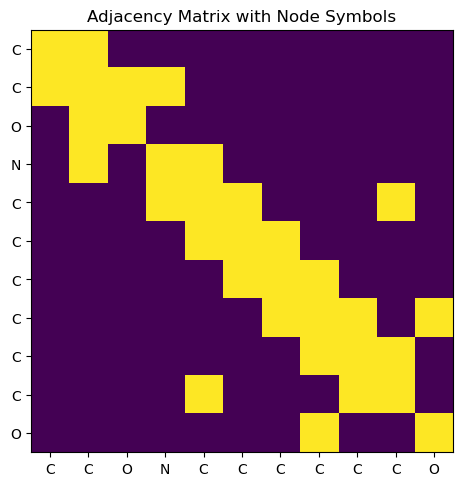

In [16]:
import numpy as np
import networkx as nx
from rdkit import Chem
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to convert SMILES to a NetworkX graph
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    graph = nx.Graph()
    for atom in mol.GetAtoms():
        graph.add_node(atom.GetIdx(), symbol=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
        # Add self-loop for each atom
        graph.add_edge(bond.GetBeginAtomIdx(), bond.GetBeginAtomIdx(), bond_type='self')
        graph.add_edge(bond.GetEndAtomIdx(), bond.GetEndAtomIdx(), bond_type='self')
    return graph

# Function to create an adjacency matrix from a NetworkX graph (sparse representation)
def create_adjacency_matrix(graph):
    return nx.adjacency_matrix(graph)

# Function to create node features based on the specified dimensions
def create_node_features(mol):
    atom_features = []
    for atom in mol.GetAtoms():
        # One-hot encoding of the atom element
        element = atom.GetSymbol()
        element_one_hot = [0] * 44
        element_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']
        if element in element_list:
            element_one_hot[element_list.index(element)] = 1

        # One-hot encoding of the degree of the atom in the molecule
        degree = atom.GetDegree()
        degree_one_hot = [0] * 11
        if degree < 11:
            degree_one_hot[degree] = 1

        # One-hot encoding of the total number of H bound to the atom
        total_num_h = atom.GetTotalNumHs()
        total_num_h_one_hot = [0] * 11
        if total_num_h < 11:
            total_num_h_one_hot[total_num_h] = 1

        # One-hot encoding of the number of implicit H bound to the atom
        implicit_h = atom.GetNumImplicitHs()
        implicit_h_one_hot = [0] * 11
        if implicit_h < 11:
            implicit_h_one_hot[implicit_h] = 1

        # Whether the atom is aromatic
        aromatic = [1] if atom.GetIsAromatic() else [0]

        # Combine all features
        atom_features.append(element_one_hot + degree_one_hot + total_num_h_one_hot + implicit_h_one_hot + aromatic)

    return np.array(atom_features)

# Process data to PyTorch Geometric Data format
def process_data(smiles_list):
    data_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        graph = smiles_to_graph(smiles)
        x = torch.tensor(create_node_features(mol), dtype=torch.float)
        adj_matrix = create_adjacency_matrix(graph)
        edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        data_list.append((data, adj_matrix))
    return data_list

# Example usage with a single SMILES string
smiles_list = ['CC(=O)NC1=CC=C(C=C1)O']
graphs = [smiles_to_graph(smiles) for smiles in smiles_list]

for i, graph in enumerate(graphs):
    if graph is not None:
        print(f"Graph {i + 1} for SMILES {smiles_list[i]}:")
        mol = Chem.MolFromSmiles(smiles_list[i])
        node_features = create_node_features(mol)
        for idx, features in enumerate(node_features):
            print(f"Node {idx + 1}:")
            print(f"Element (one-hot encoding): {features[0:44]}")
            print(f"Degree (one-hot encoding): {features[44:55]}")
            print(f"Total number of H (one-hot encoding): {features[55:66]}")
            print(f"Implicit H (one-hot encoding): {features[66:77]}")
            print(f"Aromaticity (indicator): {features[77]}")
            print()

        # Draw the graph using matplotlib
        plt.figure(figsize=(12, 6))

        # Plot adjacency matrix with node symbols
        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(create_adjacency_matrix(graph).todense(), cmap='viridis', interpolation='nearest')
        ax1.set_title('Adjacency Matrix with Node Symbols')
        node_labels = nx.get_node_attributes(graph, 'symbol')
        ax1.set_xticks(np.arange(len(node_labels)))
        ax1.set_yticks(np.arange(len(node_labels)))
        ax1.set_xticklabels(list(node_labels.values()))
        ax1.set_yticklabels(list(node_labels.values()))
        plt.colorbar(ax=ax1)

        # Plot the molecular graph
        ax2 = plt.subplot(1, 2, 2)
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, labels=nx.get_node_attributes(graph, 'symbol'), ax=ax2)
        nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'bond_type'), ax=ax2)
        ax2.set_title('Molecular Graph')
        plt.tight_layout()
        plt.show()

        # Animation to show step-by-step graph construction from adjacency matrix
        fig, ax = plt.subplots(figsize=(6, 6))
        def update(frame):
            ax.clear()
            subgraph = nx.Graph()
            for node in range(frame + 1):
                subgraph.add_node(node, symbol=list(node_labels.values())[node])
            adj = adj_matrix[:frame + 1, :frame + 1]
            for i in range(frame + 1):
                for j in range(frame + 1):
                    if adj[i, j] == 1:
                        subgraph.add_edge(i, j, bond_type='bond')
            pos = nx.spring_layout(subgraph)
            nx.draw(subgraph, pos=pos, with_labels=True, labels=nx.get_node_attributes(subgraph, 'symbol'), ax=ax)
            nx.draw_networkx_edge_labels(subgraph, pos=pos, edge_labels=nx.get_edge_attributes(subgraph, 'bond_type'), ax=ax)
            ax.set_title(f'Step {frame + 1} of Graph Construction')
            plt.tight_layout()

        anim = FuncAnimation(fig, update, frames=len(node_labels), interval=1000, repeat=True)
        plt.show()
